# Лабораторна робота №12
## Використання трансформерів

https://huggingface.co/

# Частина 1. Обробка часових рядів

## 1.1 Використання згорткових мереж для часових рядів

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

### Генерація датасету

In [2]:
time_series_length = 1000
t = np.linspace(0, 30, time_series_length)
ts = t * np.sin(t) / 3 + 2 * np.sin(t*5) + 0.5 * np.random.standard_normal(size=time_series_length)
# normalize the data
ts_norm = (ts - np.mean(ts)) / np.std(ts)

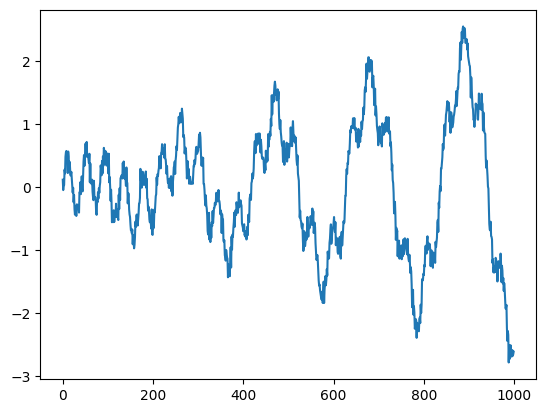

In [3]:
plt.plot(ts_norm)

In [4]:
# train-test split
train_size = int(len(ts) * 0.9)
test_size = len(ts) - train_size
train, test = ts_norm[0:train_size], ts_norm[train_size:len(ts)]

## Створення датасету

In [5]:
def create_dataset(dataset, time_steps=1):
    x, y = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        x.append(a)
        y.append(dataset[i+time_steps])
    return np.array(x), np.array(y)

In [6]:
n_time_steps = 10

x_train, y_train = create_dataset(train, n_time_steps)
x_test, y_test = create_dataset(test, n_time_steps)

In [7]:
n_inputs = 1

# reshape input to be [samples, n_time_steps, n_inputs]
x_train = np.reshape(x_train, (x_train.shape[0], n_time_steps, n_inputs))
x_test = np.reshape(x_test, (x_test.shape[0], n_time_steps, n_inputs))

### Побудова моделі

In [8]:
model =  keras.Sequential()
model.add(layers.LSTM(100, input_shape=(n_time_steps, n_inputs), return_sequences=False))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=2)

Epoch 1/5
28/28 - 7s - loss: 0.1335 - 7s/epoch - 259ms/step
Epoch 2/5
28/28 - 1s - loss: 0.0628 - 520ms/epoch - 19ms/step
Epoch 3/5
28/28 - 1s - loss: 0.0454 - 680ms/epoch - 24ms/step
Epoch 4/5
28/28 - 1s - loss: 0.0302 - 630ms/epoch - 22ms/step
Epoch 5/5
28/28 - 0s - loss: 0.0260 - 382ms/epoch - 14ms/step


In [10]:
y_pred = model.predict(x_test)

3/3 [==============================] - 2s 13ms/step


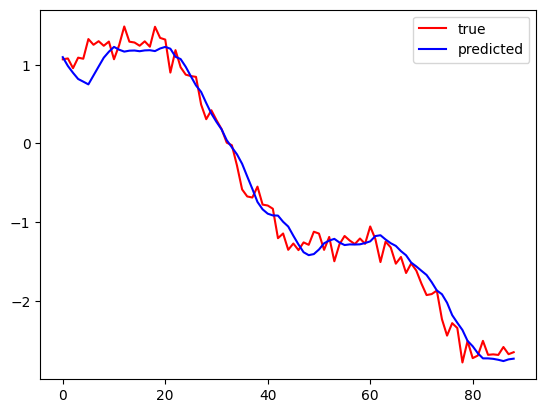

In [11]:
plt.plot(y_test, 'r', label = 'true')
plt.plot(y_pred, 'b', label = 'predicted')
plt.legend()

## 1.2 Проста модель seq2seq на основі синтетичних даних

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

In [13]:
n_timesteps_in = 50 # length of input sequence
n_timesteps_out = 40 # length of output sequence

n_features_in = 1
n_features_out = 1

### Генерація синтетичних даних

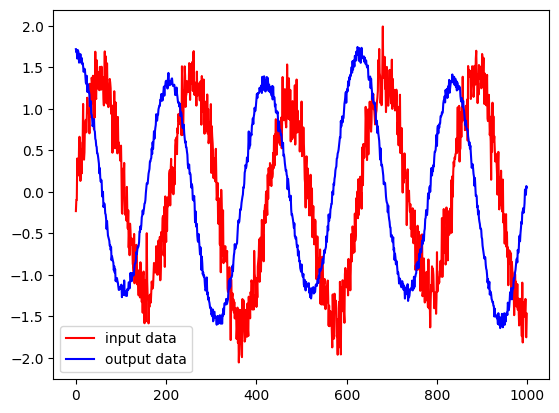

In [14]:
time_series_length = 1000
t = np.linspace(0, 10, time_series_length)
ts_input = np.sin(t) / 3 + 2 * np.sin(t*3) + 0.3 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 2 + 3 * np.cos(t*3) + 0.1 * np.random.standard_normal(size=time_series_length)
# normalize the data
ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [15]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

### Генерація датасету

In [16]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    # train data
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    # test data
    test_input_data, test_output_data = [], []
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)


In [17]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()

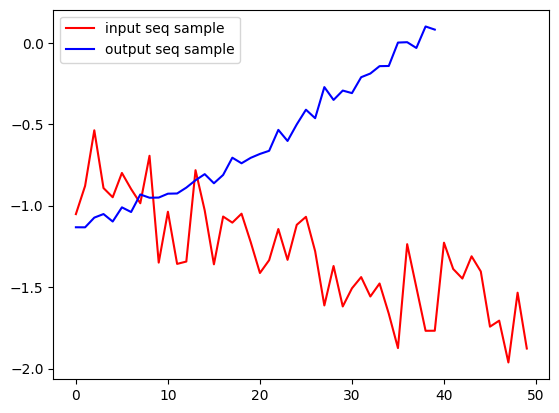

In [18]:
plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

### Побудова моделі

In [19]:
# reshape input to be [n_samples, n_time_steps, n_features]
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [20]:
n_units = 128

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Set up the decoder, using 'encoder_states' as initial state.
decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [21]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 1)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 40, 1)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               [(None, 128),                66560     ['input_1[0][0]']             
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                              

In [22]:
model.compile(optimizer='adam', loss='mse')

In [23]:
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 14s - loss: 0.8374 - val_loss: 0.6466 - 14s/epoch - 2s/step
Epoch 2/100
7/7 - 2s - loss: 0.6128 - val_loss: 0.5128 - 2s/epoch - 263ms/step
Epoch 3/100
7/7 - 2s - loss: 0.5032 - val_loss: 0.4261 - 2s/epoch - 286ms/step
Epoch 4/100
7/7 - 1s - loss: 0.3995 - val_loss: 0.2334 - 1s/epoch - 208ms/step
Epoch 5/100
7/7 - 1s - loss: 0.1941 - val_loss: 0.1252 - 1s/epoch - 180ms/step
Epoch 6/100
7/7 - 1s - loss: 0.1427 - val_loss: 0.1096 - 1s/epoch - 195ms/step
Epoch 7/100
7/7 - 1s - loss: 0.0893 - val_loss: 0.0581 - 1s/epoch - 186ms/step
Epoch 8/100
7/7 - 1s - loss: 0.0599 - val_loss: 0.0425 - 1s/epoch - 208ms/step
Epoch 9/100
7/7 - 2s - loss: 0.0439 - val_loss: 0.0541 - 2s/epoch - 230ms/step
Epoch 10/100
7/7 - 2s - loss: 0.0400 - val_loss: 0.0487 - 2s/epoch - 226ms/step
Epoch 11/100
7/7 - 2s - loss: 0.0375 - val_loss: 0.0402 - 2s/epoch - 319ms/step
Epoch 12/100
7/7 - 1s - loss: 0.0334 - val_loss: 0.0270 - 846ms/epoch - 121ms/step
Epoch 13/100
7/7 - 1s - loss: 0.0312 - val_loss

## *Результати*

In [24]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

1/1 [==============================] - 1s 733ms/step


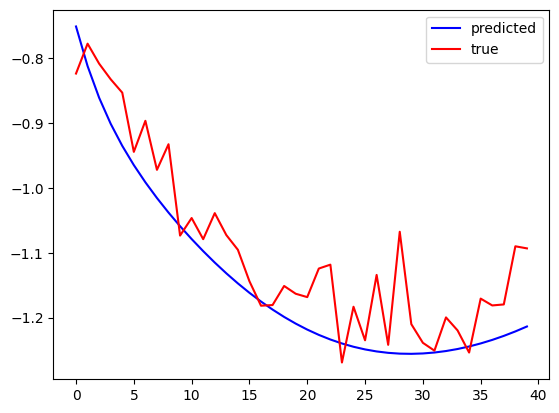

In [25]:
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()

## Частина 2. Знайомство з трансформерами для мовних моделей


Найпростіший спосіб використовувати попередньо навчену модель для даного завдання - використовувати конвеєр (pipeline).

In [26]:
# Transformers installation
#pip install transformers

from transformers import pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [27]:
txt_1 = 'Football is the most exciting and popular game in the world'
classifier(txt_1)

[{'label': 'POSITIVE', 'score': 0.9998573064804077}]

In [28]:
txt_2 = 'The weather is unpredictable around here'
classifier(txt_2)

[{'label': 'POSITIVE', 'score': 0.6950812935829163}]

## AutoTokenizer, TFAutoModelForSequenceClassification

### *Використання пайплайнів*

In [29]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [30]:
inputs = tokenizer([txt_1, txt_2])

In [31]:
inputs

{'input_ids': [[101, 2374, 2003, 1996, 2087, 10990, 1998, 2759, 2208, 1999, 1996, 2088, 102], [101, 1996, 4633, 2003, 21446, 2105, 2182, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [32]:
inputs_with_padding = tokenizer([txt_1, txt_2], padding = True, truncation = True, max_length = 256, return_tensors="tf")

In [33]:
inputs_with_padding

{'input_ids': <tf.Tensor: shape=(2, 13), dtype=int32, numpy=
array([[  101,  2374,  2003,  1996,  2087, 10990,  1998,  2759,  2208,
         1999,  1996,  2088,   102],
       [  101,  1996,  4633,  2003, 21446,  2105,  2182,   102,     0,
            0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 13), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int32)>}

In [34]:
outputs = model(inputs_with_padding)

In [35]:
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-4.24948   ,  4.605344  ],
       [-0.33054882,  0.49343646]], dtype=float32)>, hidden_states=None, attentions=None)

In [36]:
import tensorflow as tf
predictions = tf.nn.softmax(outputs[0], axis=-1)

In [37]:
predictions

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.4267136e-04, 9.9985731e-01],
       [3.0491835e-01, 6.9508165e-01]], dtype=float32)>

### **Sentiment Analysis with BERT**

In [42]:
#pip install datasets datasets from hugging face transformers
from datasets import load_dataset

ModuleNotFoundError: No module named 'datasets'

In [1]:
raw_datasets = load_dataset("imdb")

NameError: name 'load_dataset' is not defined

In [ ]:
raw_datasets

In [ ]:
raw_datasets['train']['label'][0]

In [ ]:
raw_datasets['train']['text'][0]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
def tokenize(sequence):
    tokens = tokenizer.encode_plus(sequence, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [ ]:
import numpy as np
num_of_elements = 5000

Xids = np.zeros((num_of_elements, 512))
Xmask = np.zeros((num_of_elements, 512))

idx = np.random.randint(0, 25000, num_of_elements)
small_dataset = np.array(raw_datasets['train']['text'])[idx.astype(int)]
small_dataset_labels = np.array(raw_datasets['train']['label'])[idx.astype(int)]

labels = np.array(small_dataset_labels)

In [ ]:
for i, sequence in enumerate(small_dataset):
    tokens = tokenize(sequence)
    Xids[i, :], Xmask[i, :] = tokens[0], tokens[1]

In [ ]:
 Xids[0]

In [ ]:
from transformers import TFAutoModel

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

In [ ]:
bert.summary()

In [ ]:
import tensorflow as tf

input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)

# Classifier head
x = tf.keras.layers.Dense(1024, activation ='relu')(embeddings)
y = tf.keras.layers.Dense(1, activation ='sigmoid', name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

In [ ]:
bert.bert(input_ids, attention_mask=mask) # outputs of bert

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
history = model.fit(
    [Xids, Xmask], labels,
    validation_split=0.8,
    batch_size = 16,
    verbose = 1,
    epochs=1)

# Завдання на лабораторну роботу

1. Використовуючи датасет з реальними часовими даними, побудувати згорткову мережу та трансформер для прогнозування значень часового ряду.
2. Ознайомитись з наведеними прикладом використання трансформерів для мовних моделей
3. Описати архітектуру мережі обраної з наведеного нижче рисунка


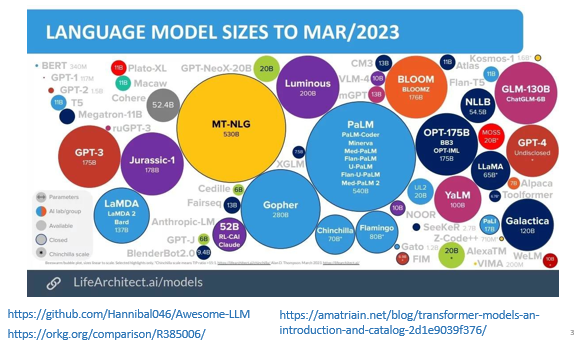